In [20]:
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

import numpy as np

from xgboost import XGBRegressor

In [3]:
from sklearn.model_selection import TimeSeriesSplit

In [4]:
df = pd.read_csv("../data/processed/fhvhv_daily_counts_features.csv")

df['pickup_date'] = pd.to_datetime(df['pickup_date'])
# set PULocationID as categorical
df["PULocationID"] = df["PULocationID"].astype("category")

df.head()

,PULocationID,pickup_date,count,day_of_week,day_of_month,month,is_weekend,lag_1,lag_7,rolling_mean_3,...,rolling_max_30,expanding_mean,expanding_median,expanding_std,expanding_min,expanding_max,diff_1,diff_7,day_of_week_sin,day_of_week_cos
0,1,2022-02-01,0,1,1,2,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530
1,1,2022-02-02,0,2,2,2,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.394356,0.918958
2,1,2022-02-03,0,3,3,2,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571268,0.820763
3,1,2022-02-04,0,4,4,2,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.724793,0.688967
4,1,2022-02-05,0,5,5,2,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.848644,0.528964


In [5]:
pd.set_option('display.max_columns', None)

In [6]:
HOLDOUT_LENGTH_W = 1

HOLDOUT_DATE_START = df.pickup_date.max() - pd.Timedelta(weeks=HOLDOUT_LENGTH_W)

HOLDOUT_DATE_START

Timestamp('2023-09-23 00:00:00')

In [7]:
holdout_df = df[df.pickup_date > HOLDOUT_DATE_START]

df = df[df.pickup_date <= HOLDOUT_DATE_START]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157800 entries, 0 to 159633
Data columns (total 38 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   PULocationID       157800 non-null  category      
 1   pickup_date        157800 non-null  datetime64[ns]
 2   count              157800 non-null  int64         
 3   day_of_week        157800 non-null  int64         
 4   day_of_month       157800 non-null  int64         
 5   month              157800 non-null  int64         
 6   is_weekend         157800 non-null  int64         
 7   lag_1              157800 non-null  float64       
 8   lag_7              157800 non-null  float64       
 9   rolling_mean_3     157800 non-null  float64       
 10  rolling_mean_7     157800 non-null  float64       
 11  rolling_mean_14    157800 non-null  float64       
 12  rolling_mean_30    157800 non-null  float64       
 13  rolling_median_3   157800 non-null  float64      

In [26]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [40]:
default_parameters = {'objective':'reg:squarederror', 'n_estimators':300, 'learning_rate':0.1, 'max_depth':5, 
                      'min_child_weight':1, 'gamma':0, 'subsample':1, 'colsample_bytree':0.3, 'alpha':10, 
                      'n_jobs':-1, 'random_state':42, 'enable_categorical':True}

In [41]:
def train_xgb(train_df, parameters = default_parameters):

    from sklearn.metrics import mean_squared_error

    X_train = train_df.drop(columns=["pickup_date", "count"])
    y_train = train_df["count"]

    xg_reg = XGBRegressor(**parameters)

    xg_reg.fit(X_train,y_train)

    # preds = xg_reg.predict(X_test)

    # rmse = np.sqrt(mean_squared_error(y_test, preds))
    # print("RMSE: %f" % (rmse))

    return xg_reg

### Creating optimisation with hyperopt

In [51]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [52]:
search_space = {
    'learning_rate': hp.loguniform('learning_rate', -7, 0),
    'max_depth': hp.quniform('max_depth', 1, 100),
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.loguniform('gamma', -10, 10),
    'alpha': hp.loguniform('alpha', -10, 10),
    'lambda': hp.loguniform('lambda', -10, 10),
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 123,
}

In [44]:
def objective(space, model, test_df):
    pred = model.predict(test_df.drop(columns=["pickup_date", "count"]))
    loss = rmse(test_df["count"], pred)
    return {'loss': loss, 'status': STATUS_OK}

## Training loop
We optimise the hyperparameters of the model using the hyperopt library.
The optimisation will happen on the latest (most recent) backtest.

Then we will just train the model with the best hyperparameters on the other backtests and evaluate it separately.


In [45]:
BACKTESTS = 3
BACKTESTS_LENGTH_W = 1

TRAIN_START = df.pickup_date.min() - pd.Timedelta(days=1)

TRAIN_LENGTH = df.pickup_date.max() - pd.Timedelta(weeks=BACKTESTS_LENGTH_W*BACKTESTS) - TRAIN_START


holdout_start = HOLDOUT_DATE_START
earliest_train_start = df.pickup_date.min()


# Calculate backtest periods
for i in range(BACKTESTS):
    backtest_end = holdout_start - pd.Timedelta(days=1)  # End date of backtest is one day before holdout starts
    backtest_start = backtest_end - pd.Timedelta(weeks=BACKTESTS_LENGTH_W) + pd.Timedelta(days=1)

    train_start = earliest_train_start + pd.Timedelta(weeks=BACKTESTS_LENGTH_W*(BACKTESTS - i-1))
    train_end = backtest_start - pd.Timedelta(days=1)

    print(f"Backtest {i+1}:")
    print(f"   Training Data: Start - {train_start.date()}, End - {train_end.date()}")
    print(f"   Backtest Data: Start - {backtest_start.date()}, End - {backtest_end.date()}")

    train_df = df[(df.pickup_date >= train_start) & (df.pickup_date <= train_end)]
    test_df = df[(df.pickup_date >= backtest_start) & (df.pickup_date <= backtest_end)]

    model_xgb = train_xgb(train_df)

    test_df['prediction'] = model_xgb.predict(test_df.drop(columns=["pickup_date", "count"]))
    
    print("RMSE for backtest {} is {}".format(i, rmse(test_df['count'], test_df['prediction'])))


    # Update the holdout start for the next backtest
    holdout_start = backtest_start #- pd.Timedelta(days=1)

Backtest 1:
   Training Data: Start - 2022-02-15, End - 2023-09-15
   Backtest Data: Start - 2023-09-16, End - 2023-09-22


/var/folders/1j/zwnv49_10lv7m7s34ngtk0kc0000gn/T/ipykernel_92415/3770635828.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['prediction'] = model_xgb.predict(test_df.drop(columns=["pickup_date", "count"]))


RMSE for backtest 0 is 270.016903365208
Backtest 2:
   Training Data: Start - 2022-02-08, End - 2023-09-08
   Backtest Data: Start - 2023-09-09, End - 2023-09-15


/var/folders/1j/zwnv49_10lv7m7s34ngtk0kc0000gn/T/ipykernel_92415/3770635828.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['prediction'] = model_xgb.predict(test_df.drop(columns=["pickup_date", "count"]))


RMSE for backtest 1 is 325.83774588030457
Backtest 3:
   Training Data: Start - 2022-02-01, End - 2023-09-01
   Backtest Data: Start - 2023-09-02, End - 2023-09-08
RMSE for backtest 2 is 412.58869613111244


/var/folders/1j/zwnv49_10lv7m7s34ngtk0kc0000gn/T/ipykernel_92415/3770635828.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['prediction'] = model_xgb.predict(test_df.drop(columns=["pickup_date", "count"]))


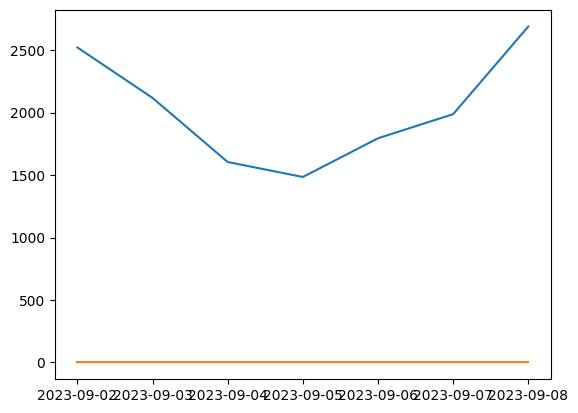

In [24]:
# plot predictions vs actuals
import matplotlib.pyplot as plt

test_df_4 = test_df[test_df['PULocationID'] == 4]
plt.plot(test_df_4['pickup_date'], test_df_4['count'], label='actual')
plt.plot(test_df_4['pickup_date'], test_df_4['prediction'], label='prediction')
